## 영화리뷰데이터 감정분석하기_http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

In [1]:
import os
import re

In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import utils

In [5]:
# 텐서플로 케라스 모듈의 get_file 함수를 통해 IMDB 데이터를 가져온다.
# tar.gz는 리눅스에서 제공하는 압축 파일을 의미한다.
# fname=''으로 파일 이름을 재지정할 수 있다. 
data_set = tf.keras.utils.get_file(fname = 'imdb.tar.gz',origin = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',extract = True)

84131840/84125825 [==============================] - 52s 1us/step


In [6]:
#재설치 방지를 위해 data_set을 변경한다. 
data_set = 'C:/Users/user/.keras/datasets/aclImdb'

In [12]:
# 모든 데이터가 디렉터리 안에 txt파일 형태로 있기 때문에 판다스의 데이터프레임을 만들기 위해서는 변환 작업을 진행해야 한다. 
def directory_data(directory): 
    data = {}
    data['review'] = []
    for file_path in os.listdir(directory):
        with open(os.path.join(directory, file_path),'r', encoding='UTF8')as file:
            data['review'].append(file.read())
    return pd.DataFrame.from_dict(data)

In [13]:
def data(directory):
    pos_df = directory_data(os.path.join(directory, 'pos'))
    neg_df = directory_data(os.path.join(directory, 'neg'))
    pos_df['sentiment'] = 1
    neg_df['sentiment'] = 0
    
    return pd.concat([pos_df, neg_df])

In [16]:
# 두 함수를 호출하여 판다스 데이터프레임을 반환 받는 구문을 만든다. 
train_df = data(os.path.join(os.path.dirname(data_set),'aclImdb', 'train'))
test_df = data(os.path.join(os.path.dirname(data_set),'aclImdb','test'))

print(train_df.head)

# 오류메세지: 'cp949' codec can't decode byte 0xe2 in position 203: illegal multibyte sequence 인 경우 해결방법
# open('파일경로.txt', 'rt', encoding='UTF8') 이렇게 open file 할 때 인코딩 해주면 된다

<bound method NDFrame.head of                                                   review  sentiment
0      Bromwell High is a cartoon comedy. It ran at t...          1
1      Homelessness (or Houselessness as George Carli...          1
2      Brilliant over-acting by Lesley Ann Warren. Be...          1
3      This is easily the most underrated film inn th...          1
4      This is not the typical Mel Brooks film. It wa...          1
...                                                  ...        ...
12495  Towards the end of the movie, I felt it was to...          0
12496  This is the kind of movie that my enemies cont...          0
12497  I saw 'Descent' last night at the Stockholm Fi...          0
12498  Some films that you pick up for a pound turn o...          0
12499  This is one of the dumbest films, I've ever se...          0

[25000 rows x 2 columns]>


In [19]:
# review에서는 각 문장을 리스트로 담고 잇다.
reviews = list(train_df['review'])

# 문자열 문장 리스트를 토크나이징
tokenized_reviews = [r.split() for r in reviews]

# 토크나이징된 리스트에 대한 각 길이를 저장
review_len_by_token = [len(t) for t in tokenized_reviews]

# 토크나이징 된 것을 부텽서 음절의 길이를 저장
review_len_by_eumjeol = [len(s.replace('','')) for s in reviews]

## 문장에 포함된 단어와 알파벳의 개수에 대한 데이터 분석을 수월하게 만들기 위함이다. 

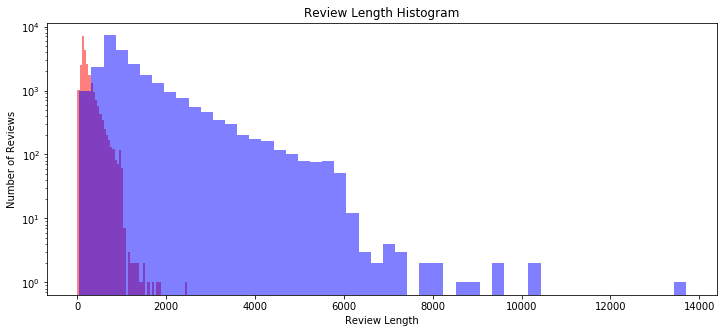

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.hist(review_len_by_token, bins=50,alpha=0.5,color='r',label='word')
plt.hist(review_len_by_eumjeol,bins=50,alpha=0.5,color='b',label='alphabet')
plt.yscale('log',nonposy='clip')
plt.title('Review Length Histogram')
plt.xlabel('Review Length')
plt.ylabel('Number of Reviews')
plt.show()

문장에 대한 길이 분포

- 빨간색 히스토그램: 단어 개수에 대한 히스토그램

- 파란색 히스토그램: 알파벳 개수에 대한 히스토그램

이를통해 단어의 단위와 알파벳의 전체적인 분포를 시각적으로 볼 수 있다. 또한 이상치값을 확인할 수 있다.

In [22]:
#데이터 분포를 통계치로 수치화한다. 
import numpy as np

print('문장 최대 길이: {}'.format(np.max(review_len_by_token)))
print('문장 최소 길이: {}'.format(np.min(review_len_by_token)))
print('문장 평균 길이: {:.2f}'.format(np.mean(review_len_by_token)))
print('문장 길이 표준편차: {:.2f}'.format(np.std(review_len_by_token)))
print('문장 중간 길이: {}'.format(np.median(review_len_by_token)))
print('제 1사분위 길이: {}'.format(np.percentile(review_len_by_token,25)))
print('제 3사분위 길이: {}'.format(np.percentile(review_len_by_token,75)))

문장 최대 길이: 2470
문장 최소 길이: 10
문장 평균 길이: 233.79
문장 길이 표준편차: 173.73
문장 중간 길이: 174.0
제 1사분위 길이: 127.0
제 3사분위 길이: 284.0


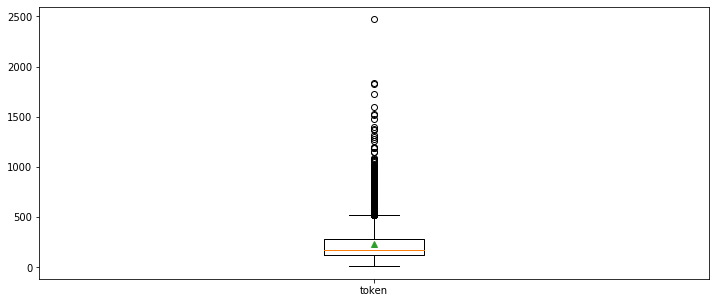

In [23]:
# 박스 플롯으로 시각화
plt.figure(figsize=(12,5))
plt.boxplot([review_len_by_token],labels=['token'],showmeans=True)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

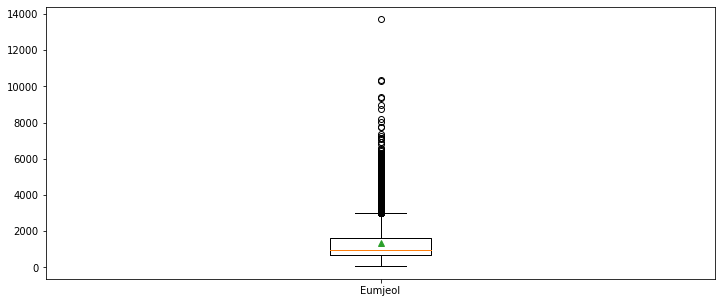

In [24]:
plt.figure(figsize=(12,5))
plt.boxplot([review_len_by_eumjeol],labels=['Eumjeol'],showmeans=True)
plt.show

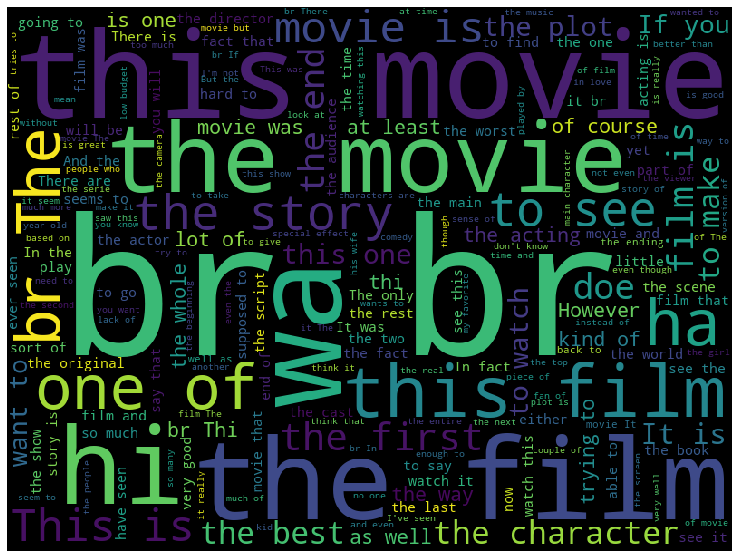

In [26]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt

wordcloud = WordCloud(stopwords = STOPWORDS,background_color = 'black', width=800, height=600).generate(''.join(train_df['review']))

plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

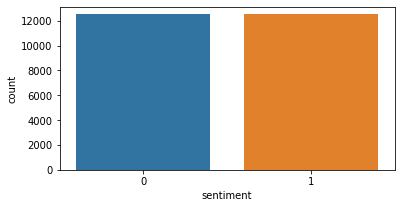

In [27]:
# 긍정과 부정의 분포 확인
import seaborn as sns
import matplotlib.pyplot as plt

sentiment = train_df['sentiment'].value_counts()
fig,axe = plt.subplots(ncols=1)
fig.set_size_inches(6,3)
sns.countplot(train_df['sentiment'])
plt.show()